In [111]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest

# Import the functions created for reusability from the Python file
from task3_1 import remove_outliers, remove_no_variance, standardise_features, pearson_correlation_matrix

## Star Dataset Pre-processing

#### Load the Star Dataset

In [112]:
star_file_name = 'datasets/star_assessment.csv'
star_features = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=range(0, 17))
star_labels = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=17, dtype=None)

In [113]:
# Explore the star dataset
print(f'Number of samples: {star_features.shape[0]}')
print(f'Number of features: {star_features.shape[1]-1}')
print(f'Number of classes: {np.unique(star_labels).shape[0]}')
print(f'Class names: {np.unique(star_labels)}')

Number of samples: 100000
Number of features: 16
Number of classes: 3
Class names: ['GALAXY' 'QSO' 'STAR']


Since there are only 3 classes, the star dataset is clearly a classification task

#### Filling in Missing Values

In [114]:
# Count the number of missing values in each column
missing_vals = np.sum(np.isnan(star_features), axis=0)
for k, v in enumerate(missing_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

Column 1: 60 missing values
Column 2: 55 missing values
Column 3: 65 missing values
Column 4: 70 missing values
Column 5: 63 missing values
Column 6: 50 missing values
Column 7: 59 missing values
Column 8: 61 missing values
Column 9: 59 missing values
Column 10: 51 missing values
Column 11: 68 missing values
Column 12: 59 missing values
Column 13: 58 missing values
Column 14: 49 missing values
Column 15: 50 missing values
Column 16: 61 missing values
Column 17: 62 missing values
Total: 1000 missing values


In [115]:
# Use a KNN imputer to fill in the missing values
knn_imputer = KNNImputer()
star_features_imputed = knn_imputer.fit_transform(star_features)

missing_vals = np.sum(np.isnan(star_features_imputed), axis=0)
print(f'Total: {sum(missing_vals)} missing values')

Total: 0 missing values


#### Encoding the Class Labels

In [116]:
# Encode the class labels
label_encoder = LabelEncoder()
star_labels_encoded = label_encoder.fit_transform(star_labels)

print(f'Encoded labels: {np.unique(star_labels_encoded)}')

Encoded labels: [0 1 2]


#### Removing Samples with Outliers

In [117]:
sample_size_with_outliers = star_features_imputed.shape[0]
star_features_without_outliers, star_labels_without_outliers = remove_outliers(star_features_imputed, star_labels_encoded)

print(f'Number of samples: {sample_size_with_outliers - star_features_without_outliers.shape[0]}')

Number of samples: 14387


#### Remove Features with No Variance

In [118]:
# Use a variance threshold to remove any features with zero variance
star_features_no_variance_removed, removed_columns = remove_no_variance(star_features_without_outliers)

print(f"Removed column indexes: {removed_columns}")

Removed column indexes: [9]


In this case, the `rerun_ID` feature has zero variance, so it is removed.


#### Feature Scaling

Scale the features to have a mean of 0 and a standard deviation of 1 before feature selection to avoid biasing the feature selection process with high-scale features.

In [119]:
# Scale the features
star_features_standardised = standardise_features(star_features_no_variance_removed)

#### Feature Selection Using the Filter Method

In [120]:
# Then use the f_classif method to determine the correlation between each feature and the class labels
select_k_best = SelectKBest(k='all')
_ = select_k_best.fit_transform(star_features_standardised, star_labels_without_outliers)

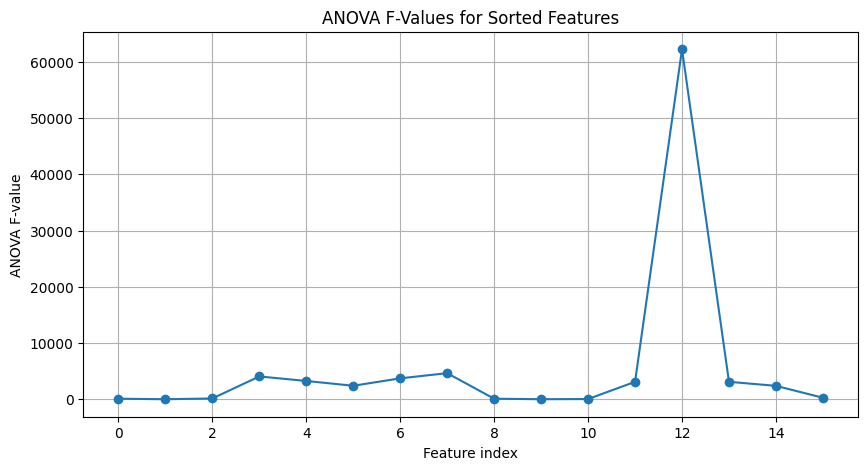

In [121]:
# Plot the sorted ANOVA F-values
plt.figure(figsize=(10, 5))
plt.plot(select_k_best.scores_, marker='o')
plt.xlabel('Feature index')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-Values for Sorted Features')
plt.grid(True)

# Display the plot
plt.show()

Based on the plot above, we can see that the features with indexes  3 (`u`), 4 (`g`), 5 (`r`), 6 (`i`), 7 (`z`), 11 (`spec_obj_ID`), 12 (`redshift`), 13 (`plate`), and 14 (`MJD`) have significantly higher ANOVA F-values than the other features, thus they have a stronger influence on the target. Additionally, the upon further investigation into what each column represents through visiting [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), seemingly these features are the most relevant to the classification of an object as a star, galaxy, or quasar.

Therefore, the features that will be dropped are:
- `obj_ID`: given that it is just an identifier, it does not provide any useful information for classification and would only add noise to the model.
- `alpha`: this feature represents the right ascension of the object, which is a coordinate used to locate objects in the sky. It shouldn't provide any benefit to the model in the classification of an object as a star, galaxy, or quasar as they are distributed across the sky.
- `delta`: similar to `alpha`, this column represents the declination of the object, which is also a coordinate for locating objects thus it shouldn't provide any benefit to the model.
- `run_ID`: this feature refers to a specific scan of the sky, which is an identifier for the run that the object was observed in. It shouldn't provide any benefit to the model as it isn't related to the detection of an object as a star, galaxy, or quasar.
- `cam_col`: this feature represents the camera column used during the observation. Like the `run_ID`, it is not related to the object's properties thus is less relevant to the classification task.
- `field_ID`: this feature represents the field number of the observation. It is also not related to the object's properties so shouldn't be relevant to the classification task.
- `fiber_ID`: this refers to the fiber number used to capture the spectrum of the object. The feature is not related to the object's properties so won't provide any benefit to the model.

In [122]:
# Drop the features as described above
star_features_selected = np.delete(star_features_standardised, [0, 1, 2, 8, 9, 10, 15], axis=1)

# Print the number of features
print(f'Number of features: {star_features_selected.shape[1]}')

Number of features: 9


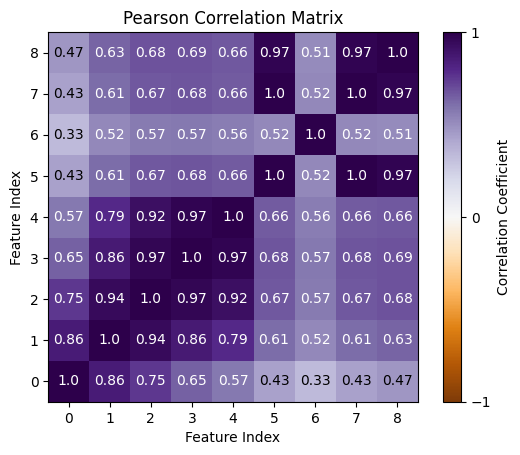

In [123]:
pearson_correlation_matrix(star_features_selected)

From this matrix, it is clear that the following features are highly correlated:
- 0 (`u`), 1 (`g`), 2 (`r`), 3 (`i`) and 4 (`z`) have a chain of correlations
- 5 (`spec_obj_ID`), 7 (`plate`) and 8 (`MJD`) have linear correlations

It makes sense that several of the features related to the photometric system are correlated as they represent the intensity of the object's light at different wavelengths. Since objects emit light across a range of wavelengths, it is expected that the light will be correlated across the different filters.

## GWP Dataset Pre-processing

#### Load the GWP dataset

In [124]:
gwp_file_name = 'datasets/gwp_assessment.csv'
gwp_categorical = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=str, usecols=range(0, 4))
gwp_floats = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=range(4, 14))
gwp_values = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=14)

In [125]:
# Explore the gwp dataset
print(f'Number of samples: {gwp_categorical.shape[0]}')
print(f'Number of features: {gwp_categorical.shape[1] + gwp_floats.shape[1]}')
print(f'Number of classes: {np.unique(gwp_values).shape[0]}')

Number of samples: 1197
Number of features: 14
Number of classes: 879


Since there are 879 classes, this is clearly a regression task. Additionally, unlike the star dataset, since there are categorical features in this dataset, these will need to be explored and encoded appropriately

#### Explore Categorical Features

First let's look at `quarter`, `date` and `day`

In [126]:
unique_quarter_values, counts = np.unique(gwp_categorical[:, 1], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_quarter_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: , Count: 11
Value: Quarter1, Count: 357
Value: Quarter2, Count: 332
Value: Quarter3, Count: 207
Value: Quarter4, Count: 246
Value: Quarter5, Count: 44


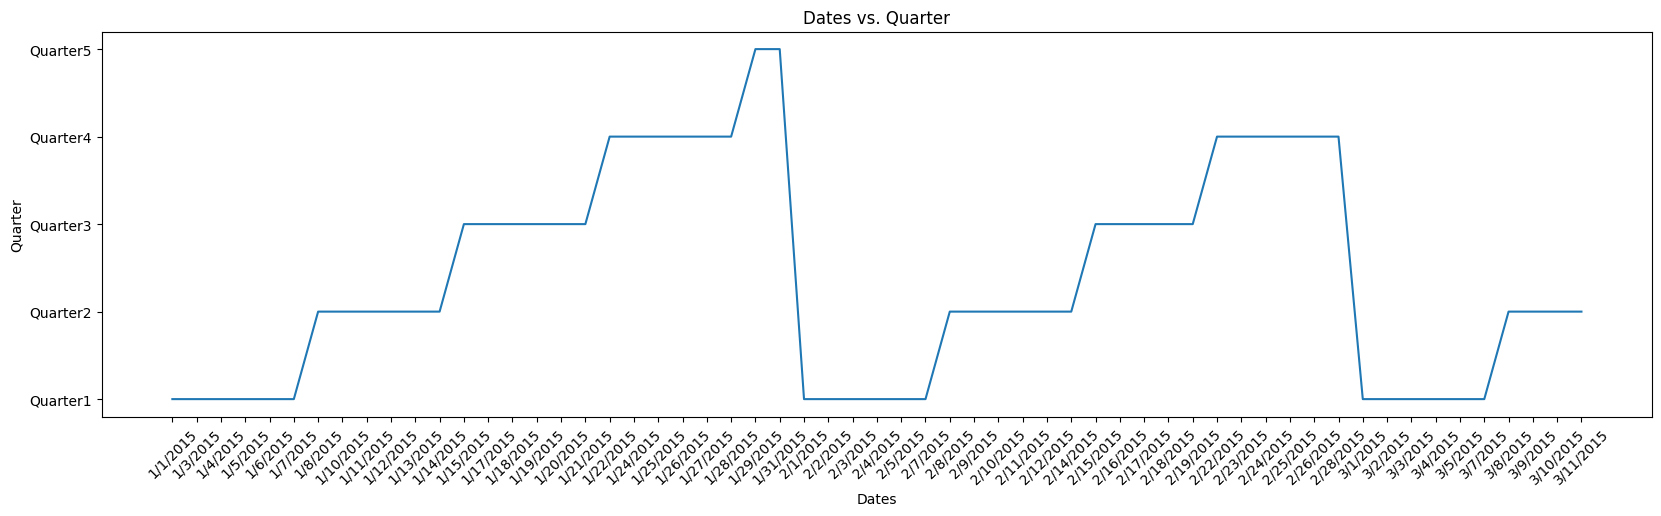

In [127]:
# Plot the dates against each quarter
plt.figure(figsize=(20, 5))
gwp_categorical_no_nulls = gwp_categorical[~(gwp_categorical == "").any(axis=1)]
plt.plot(gwp_categorical_no_nulls[:, 0], gwp_categorical_no_nulls[:, 1])
plt.xlabel('Dates')
plt.ylabel('Quarter')
plt.title('Dates vs. Quarter')
plt.xticks(rotation=45)

plt.show()

From the plot above, it is clear that quarters 1, 2, 3 and 4 usually follow a consistent pattern in their length (one week) and when they occur (start every Thursday). The main point of deviation from this pattern is quarter 5, which happens once and appears to last for only two days.

In [128]:
# Let's determine whether any samples are missing more than one of the date, day and quarter features
missing_samples = np.column_stack((gwp_categorical[:, 0] == '', gwp_categorical[:, 1] == '', gwp_categorical[:, 3] == ''))
missing_count = np.sum(missing_samples, axis=1)
rows_with_multiple_missing = np.where(missing_count > 1)[0]

print(f"Number of rows with more than one missing value: {rows_with_multiple_missing.shape[0]}")

Number of rows with more than one missing value: 0


Since no rows are missing more than one of the date, day and quarter features, the missing value can be inferred from the remaining features.

In [129]:
# Next let's look at the `department` feature
unique_values, counts = np.unique(gwp_categorical[:, 2], return_counts=True)

# Print unique values along with their counts
for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

Value: , Count: 7
Value: finishing, Count: 246
Value: finishing , Count: 257
Value: sweing, Count: 687


There appears to be two departments, `sweing` and `finishing`. However, some `finishing` values have been entered with a trailing space, which will need to be removed.

In [130]:
# Remove the trailing space from the `finishing` values
gwp_categorical[:, 2] = np.char.strip(gwp_categorical[:, 2])

#### Encode Categorical Features

We can use one-hot encoding to encode the `quarter`, `department` and `day` features

In [131]:
# Create a new numpy array
gwp_categorical_ohc = np.empty((gwp_categorical.shape[0], 0))
for i in range(1, 4):
    ohc = OneHotEncoder(categories='auto', dtype=float, sparse_output=False)
    ohc.fit(gwp_categorical[:, [i]])
    new_col = ohc.transform(gwp_categorical[:, [i]])
    gwp_categorical_ohc = np.concatenate([gwp_categorical[:, :i], new_col, gwp_categorical[:, i+1:]], axis=1)

1
2
3


In [133]:
print(gwp_categorical[0])

['1/1/2015' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0' 'sweing'
 'Thursday']


#### Remaining Missing Values

In [132]:
# Count the number of missing values in each column
missing_string_vals = np.sum(np.char.strip(gwp_categorical) == '', axis=0)
missing_float_vals = np.sum(np.isnan(gwp_floats), axis=0)
missing_vals = np.concatenate((missing_string_vals, missing_float_vals))
for k, v in enumerate(missing_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

Column 1: 18 missing values
Column 2: 0 missing values
Column 3: 0 missing values
Column 4: 0 missing values
Column 5: 0 missing values
Column 6: 0 missing values
Column 7: 0 missing values
Column 8: 0 missing values
Column 9: 0 missing values
Column 10: 7 missing values
Column 11: 15 missing values
Column 12: 12 missing values
Column 13: 17 missing values
Column 14: 8 missing values
Column 15: 506 missing values
Column 16: 9 missing values
Column 17: 5 missing values
Column 18: 12 missing values
Column 19: 12 missing values
Column 20: 13 missing values
Column 21: 10 missing values
Total: 644 missing values
